## ML model on Wine reviews dataset (utilising Word2vec embedding for reviews)-

### Objective-

To develop an ML model capable of predicting the wine “variety” using the reviews(text field) and other additional information about the wine. 

#### The Data Description is as follows:
1.	user_name - user_name of the reviewer
2.	country -The country that the wine is from.
3.	review_title - The title of the wine review, which often contains the vintage.
4.	review_description - A verbose review of the wine.
5.	designation - The vineyard within the winery where the grapes that made the wine are from.
6.	points - ratings given by the user. The ratings are between 0 -100.
7.	price - The cost for a bottle of the wine
8.	province - The province or state that the wine is from.
9.	region_1 - The wine-growing area in a province or state (ie Napa).
10.	region_2 - Sometimes there are more specific regions specified within a wine-growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank.
11.	winery - The winery that made the wine
12.	variety - The type of grapes used to make the wine. Dependent variable for task 2 of the assignment


### Importing neccesary packages-

In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from scipy.stats import chi2_contingency,chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import gensim.models.word2vec as w2v
from collections import Counter
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from category_encoders import OneHotEncoder
from sklearn.metrics import f1_score

In [11]:
data=pd.read_csv("train.csv")
print("No of rows:{}".format(data.shape[0]))
print("No of features:{}".format(data.shape[1]))
data.head()

No of rows:82657
No of features:12


,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [6]:
data.describe(include="all")

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
count,63264,82622,82657,82657,59010,82657.000000,77088.000000,82622,69903,35949,82657,82657
unique,15,38,76983,77628,26424,NaN,NaN,358,1019,17,13786,28
top,@vossroger,US,Korbel NV Brut Sparkling (California),"Mild raisin, black cherry, anise and burnt tir...",Reserve,NaN,NaN,California,Napa Valley,Central Coast,Testarossa,Pinot Noir
freq,17539,38573,8,2,1382,NaN,NaN,25736,3334,7503,175,10587
mean,NaN,NaN,NaN,NaN,NaN,88.544564,36.922232,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.099649,43.698346,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,86.000000,18.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,88.000000,27.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,91.000000,45.000000,NaN,NaN,NaN,NaN,NaN


In [8]:
data.isnull().sum()

user_name             19393
country                  35
review_title              0
review_description        0
designation           23647
points                    0
price                  5569
province                 35
region_1              12754
region_2              46708
winery                    0
variety                   0
dtype: int64

#### Inferences- 
1. There are only two numerical features price and points.
2. This being a reviews dataset, there are no NULL values present in review_title, review_description ,points, winery and variety features. 
3. Rest additional features contain NULL values like user_name,region_1 etc.
4. Features designation, province, region_1 and winery are too granular (large number of unique values) & region_2 has large amount of NULL values, hence these features will not be considered in the analysis. 
   Also, the feature country will account for the information related to topography (Region specific wines)

In [17]:
data= data.drop(["designation", "province", "region_1","region_2","winery"],axis=1) # removing granular features for the current analysis

In [13]:
data.drop_duplicates(inplace=True)  # dropping duplicate rows 
data=data.reset_index(drop=True)

In [18]:
print("After dropping duplicate observations(rows) and granular features:")
print("No of rows:{}".format(data.shape[0]))
print("No of features:{}".format(data.shape[1]))

After dropping duplicate observations(rows) and granular features:
No of rows:77641
No of features:8


In [19]:
data.columns

Index(['user_name', 'country', 'review_title', 'review_description', 'points',
       'price', 'winery', 'variety'],
      dtype='object')

#### Exploratory Data Analysis - 

### 1. Feature - user_name

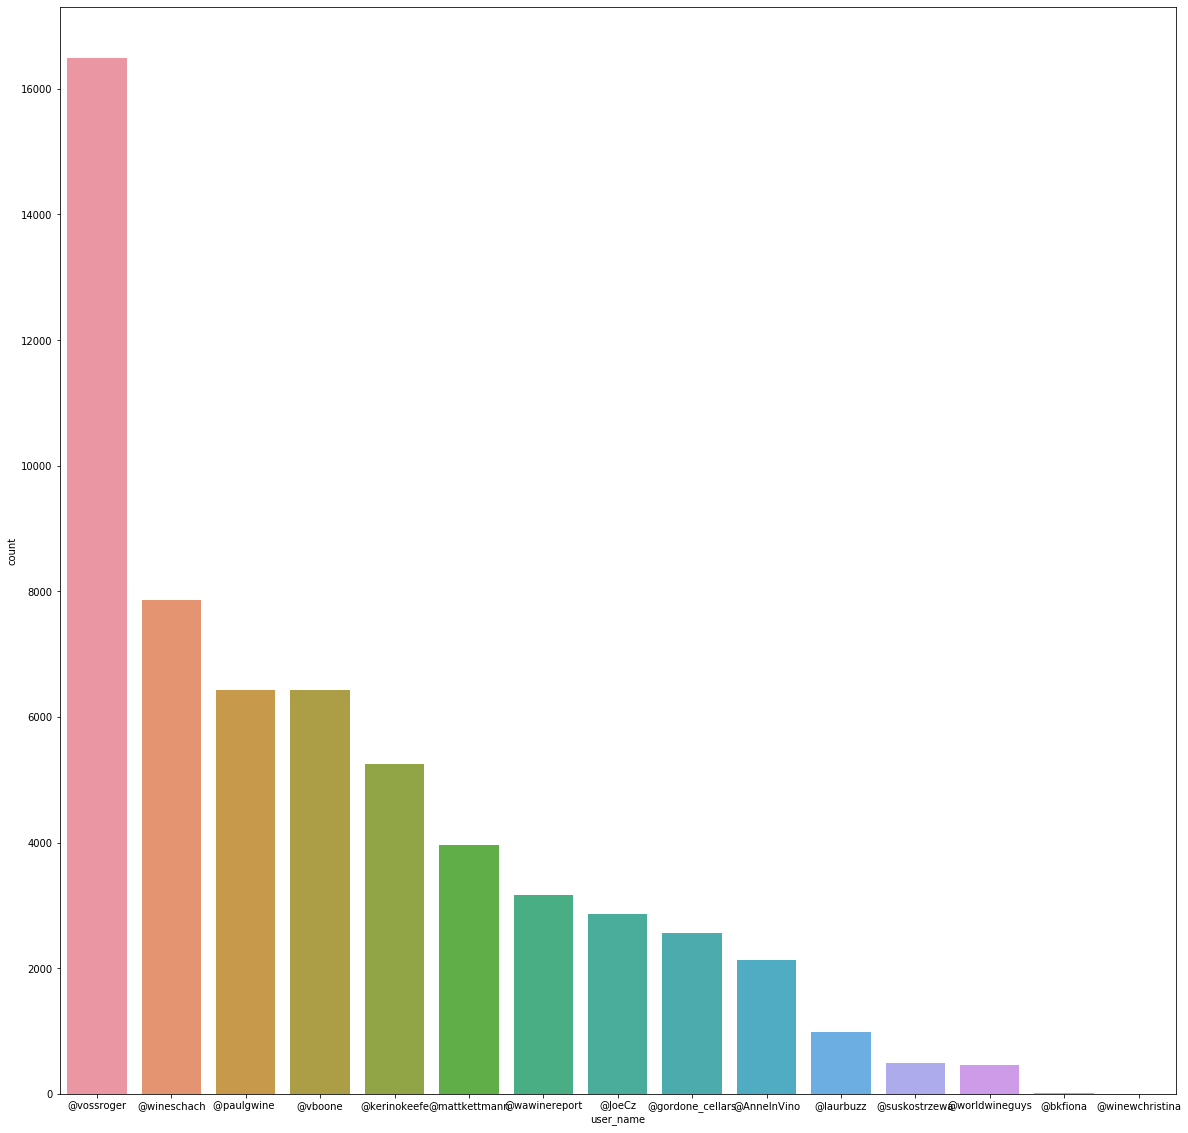

In [24]:
plt.figure(figsize=(20,20))
sns.countplot(data.user_name,order=data.user_name.value_counts().keys())
plt.show()

In [37]:
print('Percentage of each unique value-')
data.user_name.value_counts(normalize=True)*100

Percentage of each unique value-


@vossroger          27.885966
@wineschach         13.293292
@paulgwine          10.885712
@vboone             10.875560
@kerinokeefe         8.879113
@mattkettmann        6.713476
@wawinereport        5.358261
@JoeCz               4.850689
@gordone_cellars     4.321123
@AnneInVino          3.612216
@laurbuzz            1.669909
@suskostrzewa        0.830725
@worldwineguys       0.786735
@bkfiona             0.030454
@winewchristina      0.006768
Name: user_name, dtype: float64

#### chi2 test- 
An often quoted guideline for the validity of chi2 test is that the test should be used only if the observed and expected frequencies in each cell are at least 5. This not the case in this dataset hence we will not be using chi2 test. 

Review Counts per variety for @vossroger:


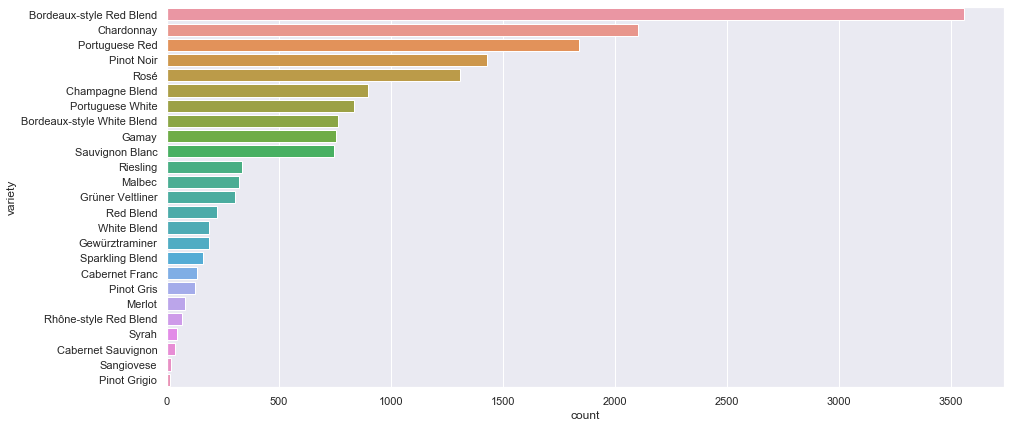

Review Counts per variety for @wineschach:


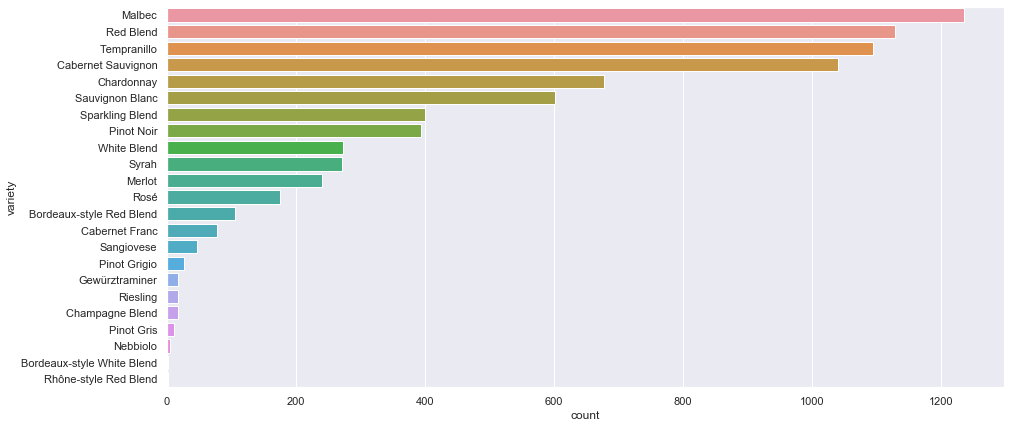

Review Counts per variety for @paulgwine :


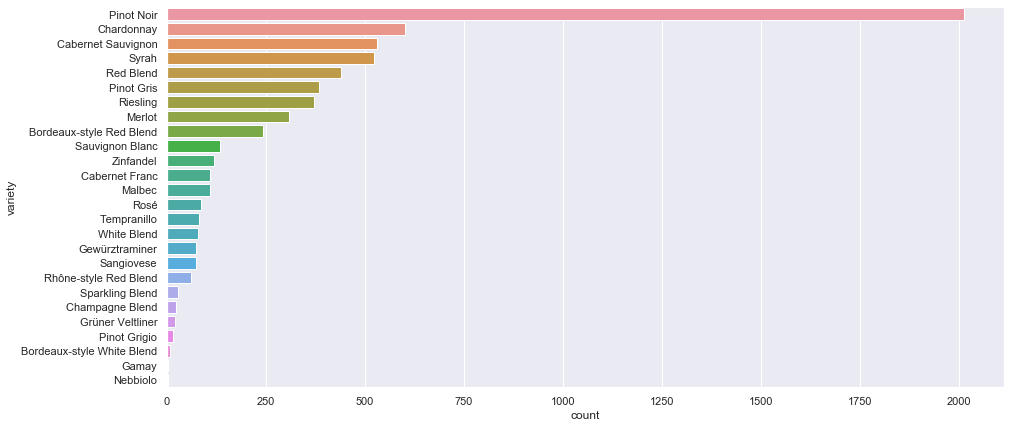

Review Counts per variety for @vboone:


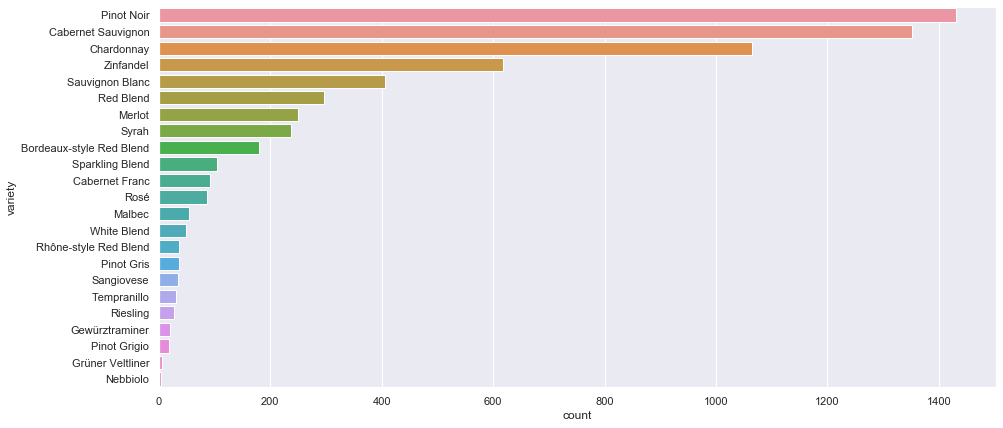

Review Counts per variety for @kerinokeefe:


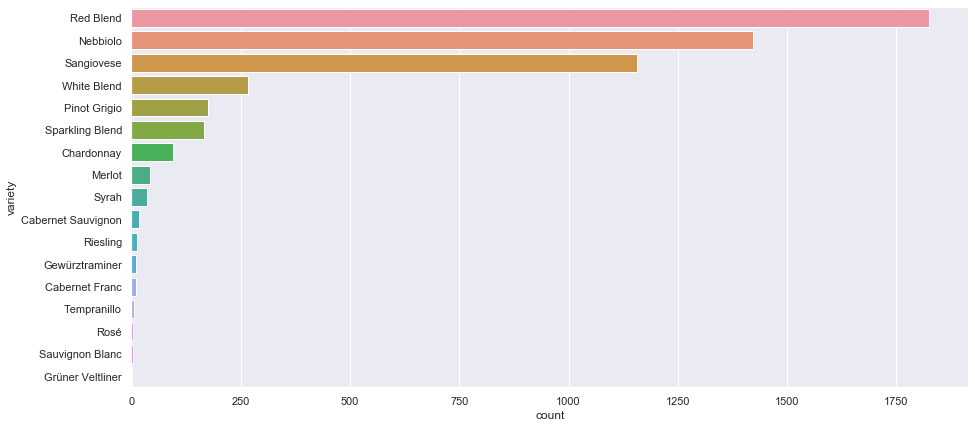

Review Counts per variety for @mattkettmann:


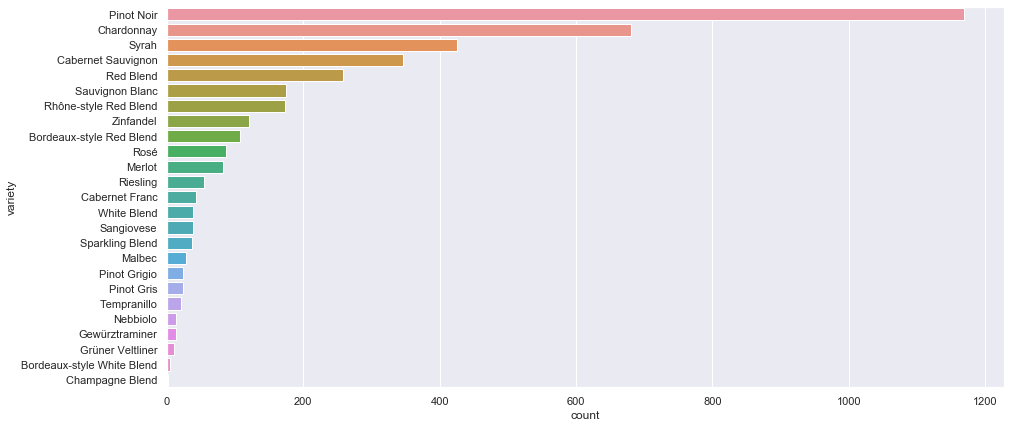

Review Counts per variety for @wawinereport:


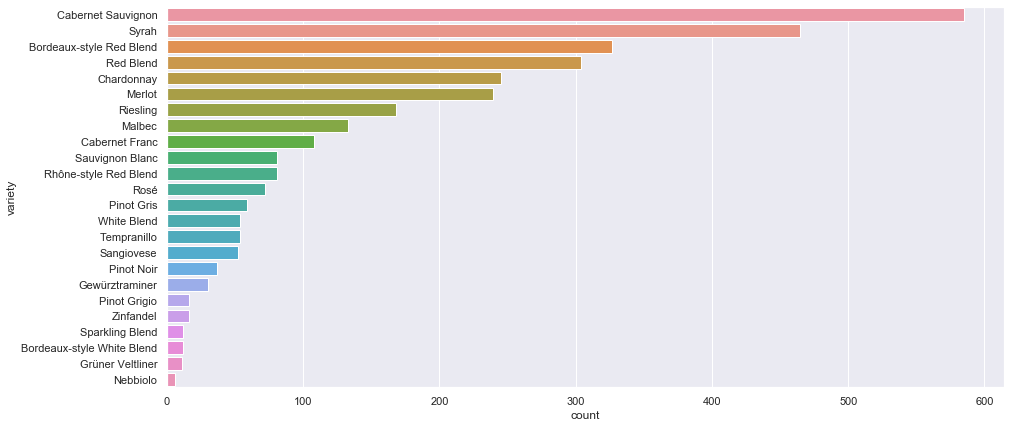

Review Counts per variety for @JoeCz:


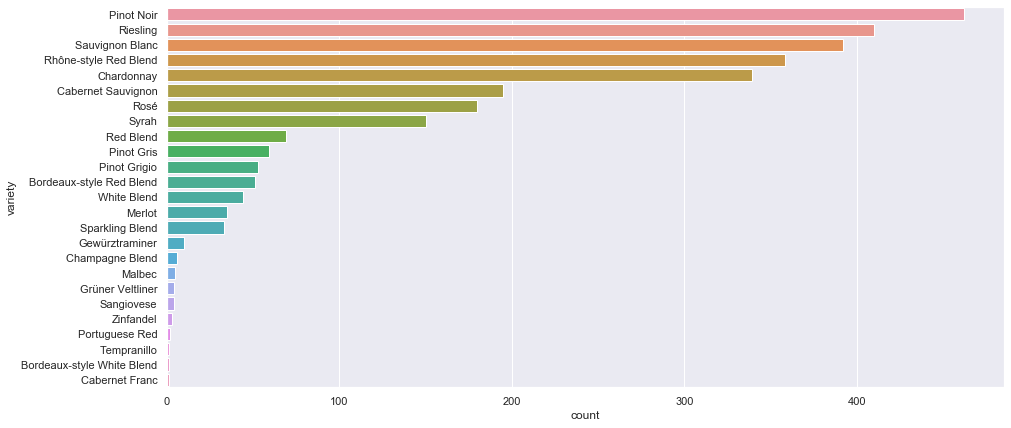

Review Counts per variety for @gordone_cellars:


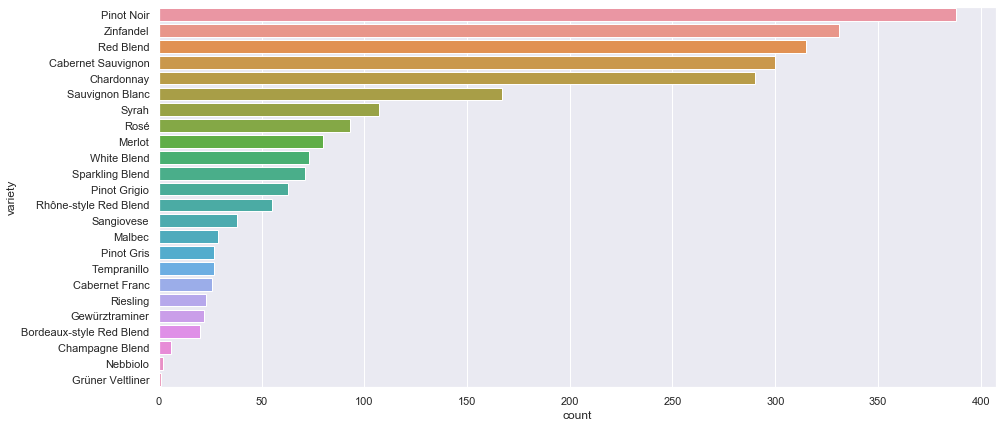

Review Counts per variety for @AnneInVino:


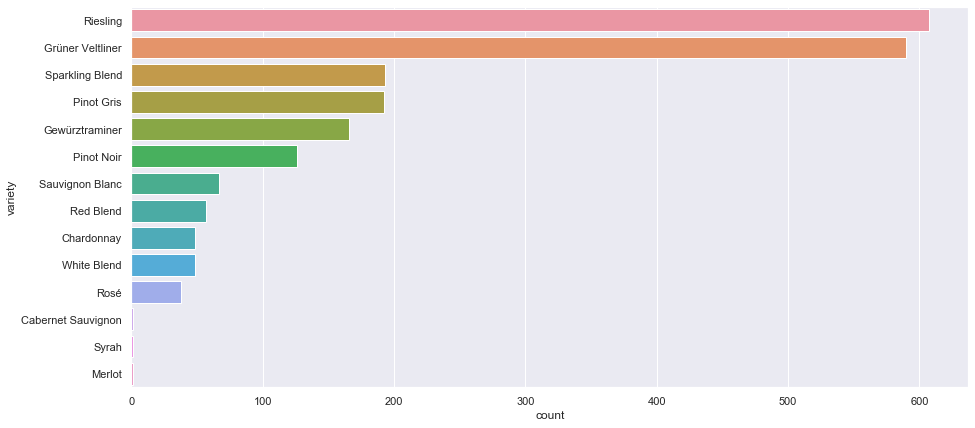

Review Counts per variety for @laurbuzz:


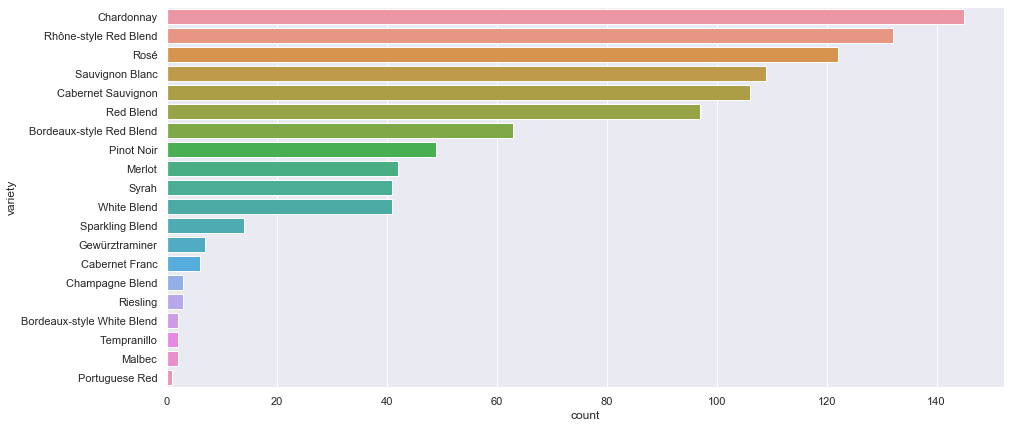

Review Counts per variety for @suskostrzewa:


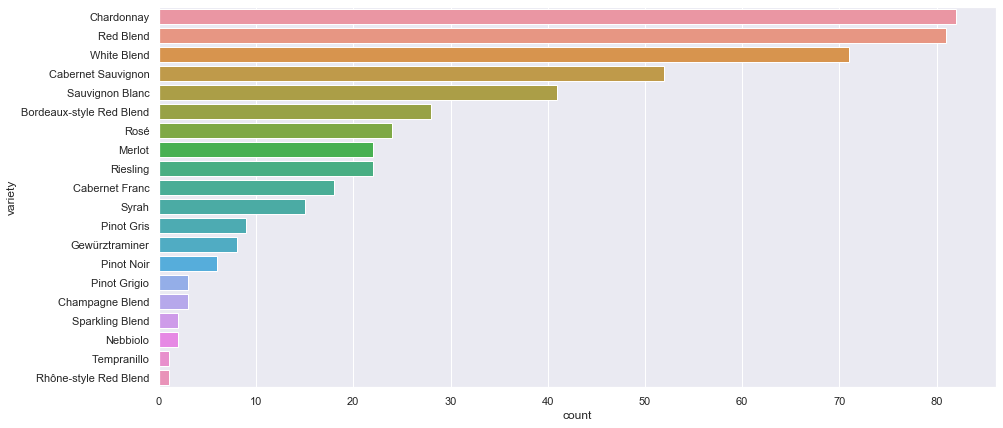

Review Counts per variety for @worldwineguys:


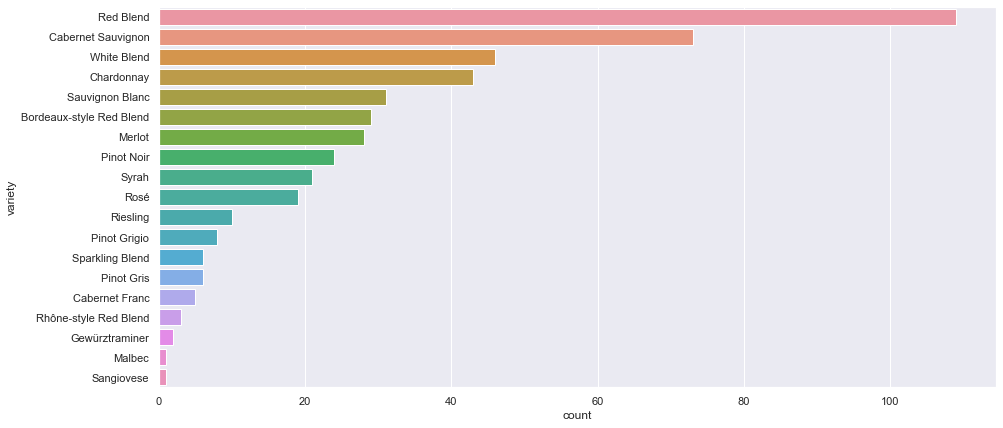

Review Counts per variety for @bkfiona:


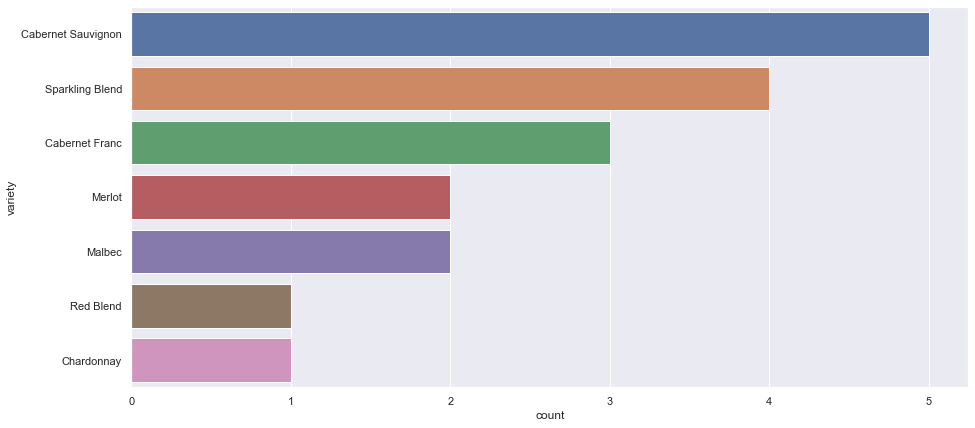

Review Counts per variety for @winewchristina:


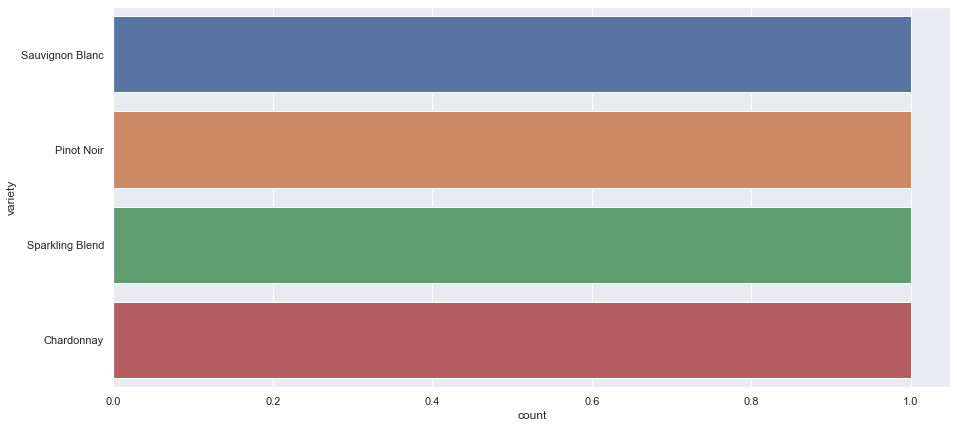

In [60]:
for i in data.user_name.value_counts().keys():
    print('Review Counts per variety for {}:'.format(i))
    plt.figure(figsize=(15,7))
    sns.countplot(y=data[data.user_name==i]['variety'],order=data[data.user_name==i]['variety'].value_counts().keys())
    plt.show()
    

Inferences- 
1. The above plots can be used to answer different questions at the critic( user_name ) level. For instance which variety is reviewed the most by @suskostrzewa, or the relative proportion of different varieties, or top 3 most reviewed for each username,etc.
2. The plots are also arranged in decreasing order of no of reviews, so we have an idea who has reviewd the most among all (@vossroger)
3. Each username has a different distribution for number of reviews for each variety, hence can be used to predict variety.
4. It is evident from the plots that few critics having very less number of reviews. Hence to reduce the number of features(after one hot encoding user_name feature) , I will keep the top 10 critics(in terms of number of reviews) and bin the remaining in Unknown category. 
5. user_name feature has a lot of NULL values too, they will be binned to the Unknown category.  

Function to bin infrequent critics and NULL values - 

In [189]:
target = data.user_name.value_counts()[:10].keys()    
def username_bins_func(user_name):        
    if user_name not in target:         # Keeping only top 10 
        return ("unknown")
    else : 
        return user_name

### 2. Feature - country  

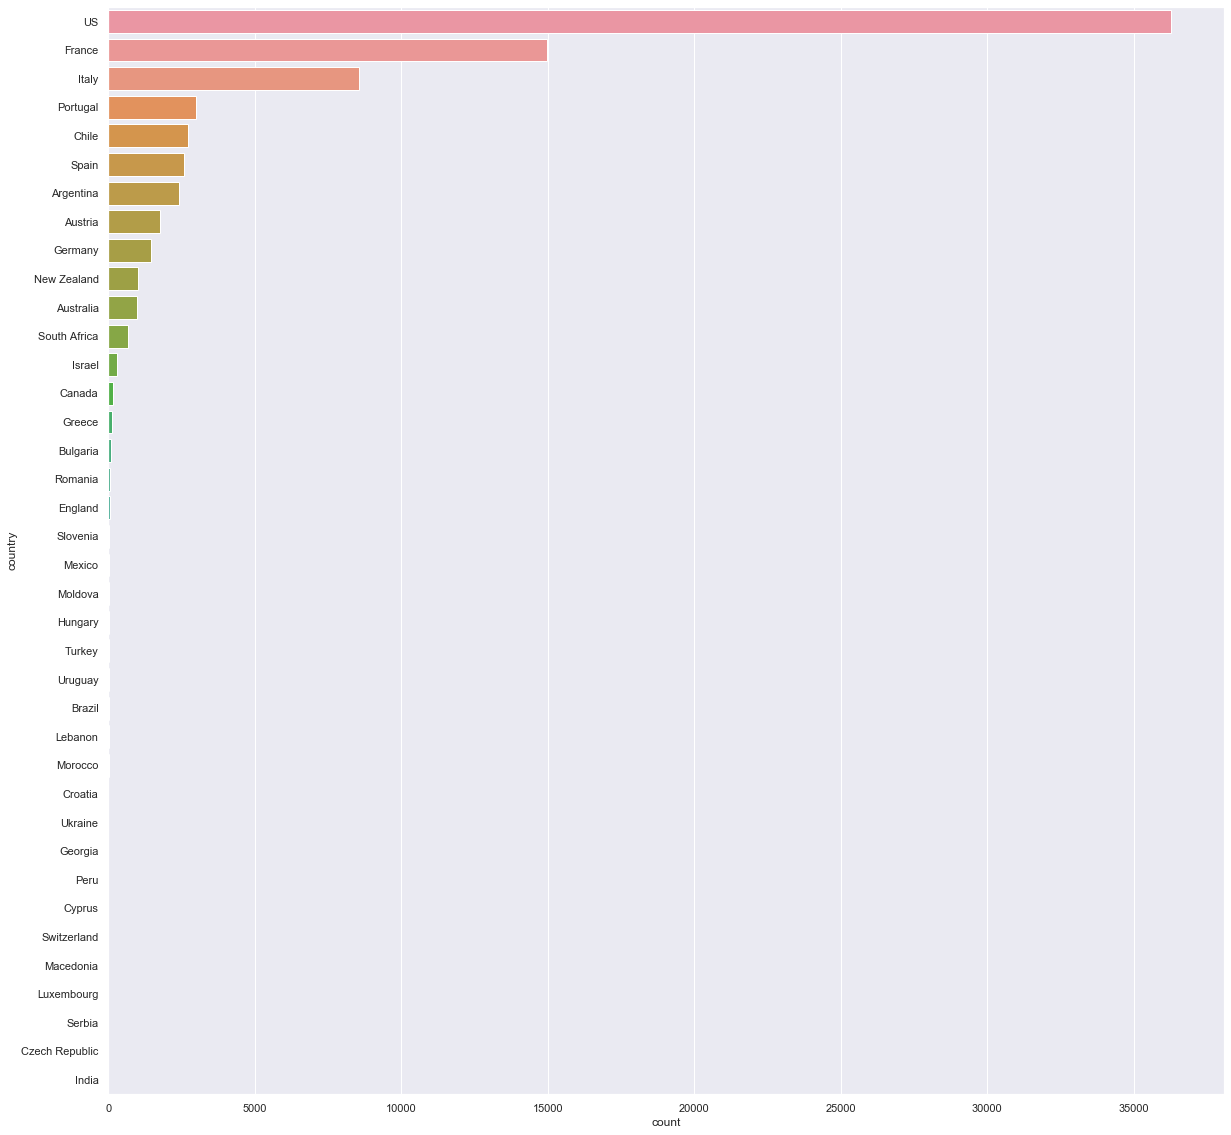

In [64]:
plt.figure(figsize=(20,20))
sns.countplot(y=data.country,order=data.country.value_counts().keys())
plt.show()

In [65]:
print('Percentage of each unique value-')
data.country.value_counts(normalize=True)*100

Percentage of each unique value-


US                46.733584
France            19.286671
Italy             11.009174
Portugal           3.863004
Chile              3.530564
Spain              3.328265
Argentina          3.134986
Austria            2.280693
Germany            1.888981
New Zealand        1.331048
Australia          1.257602
South Africa       0.873621
Israel             0.390424
Canada             0.197145
Greece             0.173951
Bulgaria           0.117256
Romania            0.088908
England            0.070869
Slovenia           0.048964
Mexico             0.048964
Moldova            0.043810
Hungary            0.041233
Turkey             0.041233
Uruguay            0.037367
Brazil             0.036079
Lebanon            0.034790
Morocco            0.024482
Croatia            0.015462
Ukraine            0.014174
Georgia            0.014174
Peru               0.010308
Cyprus             0.007731
Switzerland        0.005154
Macedonia          0.005154
Luxembourg         0.005154
Serbia             0

### Plot for top 4 countries - 

Review Counts per variety for US:


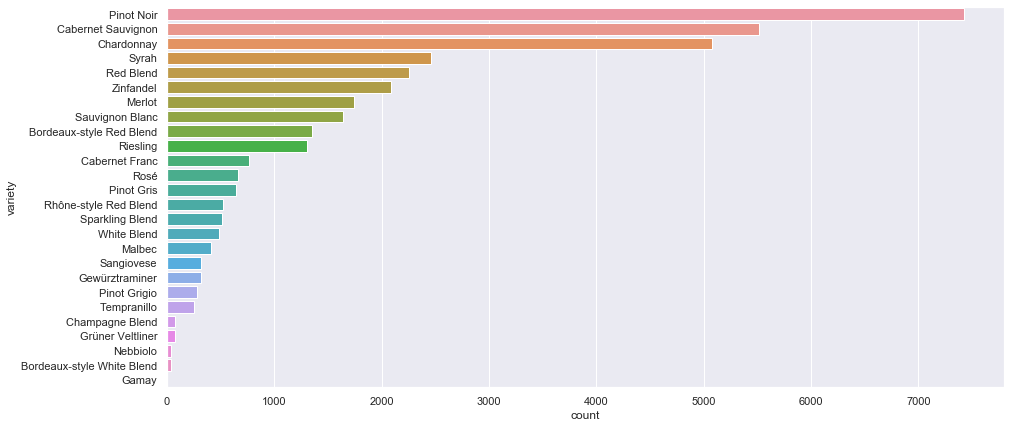

Review Counts per variety for France:


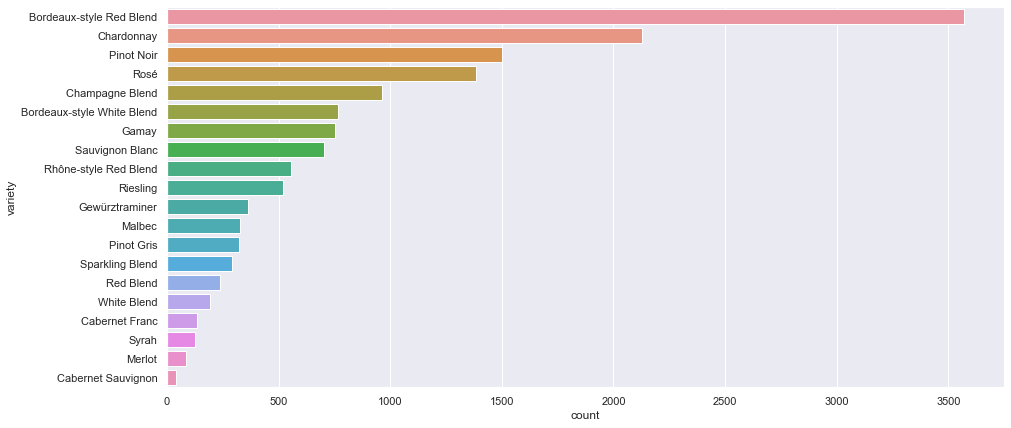

Review Counts per variety for Italy:


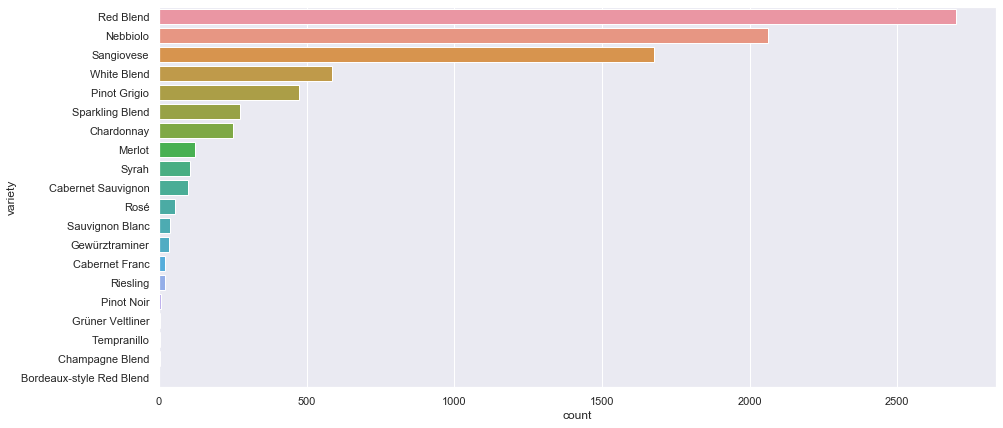

Review Counts per variety for Portugal:


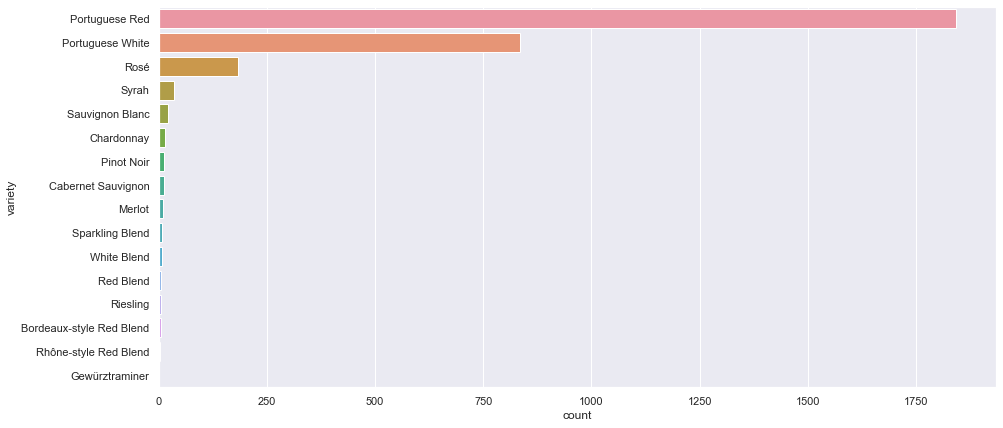

In [66]:
for i in data.country.value_counts().keys()[:4]:
    print('Review Counts per variety for {}:'.format(i))
    plt.figure(figsize=(15,7))
    sns.countplot(y=data[data.country==i]['variety'],order=data[data.country==i]['variety'].value_counts().keys())
    plt.show()
    

Inferences- 
1. The above plots can be used to make intresting findings about the dataset. For instance USA , France and Italy are the most reviewd, or the relative proportion of different varieties for cuntries, or top 3 most reviewed for each country,etc.
3. Top variety reviewed in countries are distinct, hence can be used for predictions. For example Pinot Noir is extremely popular (hence most reviewed) in US while it falls in popularity in Italy. 
4. It is evident from the plots that few country varities have very less number of reviews. Hence to reduce the number of features(after one hot encoding country feature) , I will keep the top 4 countries(in terms of number of reviews) and bin the remaining in Unknown category. 
5. country feature has NULL values too, they will be binned to the Others category.  

Function to bin infrequent countries and NULL values (rows with NULL in countries also had NULL in povince feature) -

In [67]:
target_country = data.country.value_counts().keys()[0:4]  # lets take the top 4 and bin the rest
def country_bin(country):
    if country not in target_country:  # Excluding 
        return ("Others")
    else : 
        return country

### 3. Feature- review_title

This feature is a text feature, to get an idea about its nature lets take a look at the first Ten
review_title along with the variety(dependent)-

In [77]:
for i in range(10):
    print(i+1,":")
    print(data.review_title[i])
    print(data.variety[i])
    print(data.winery[i])
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

1 :
Andrew Peace 2007 Peace Family Vineyard Chardonnay (South Eastern Australia)
Chardonnay
Andrew Peace
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
2 :
North by Northwest 2014 Red (Columbia Valley (WA))
Red Blend
North by Northwest
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3 :
Renato Ratti 2007 Conca  (Barolo)
Nebbiolo
Renato Ratti
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4 :
Domaine l'Ancienne Cure 2010 L'Abbaye White (Bergerac Sec)
Bordeaux-style White Blend
Domaine l'Ancienne Cure
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
5 :
Château du Cèdre 2012 Le Cèdre Vintage Malbec (Vin de Liqueur)
Malbec
Château du Cèdre
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
6 :
Andean 2005 Finca La Escondida Reserva Cabernet Sauvignon (San Juan)
Cabernet Sauvignon
Andean
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
7 :
Gordon Estate 2012 Tradition Red (Columbia Valley (WA))
Red Blend
Gordon Estate
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
8 :
Rock Wall 2014 M

Inference- 
1. In some review titles variety or a part of the variety is mentioned . We can extract it as a feature - hint .
2. It also contains the vintage year. Will be extracted into a new feature - vintage
3. Name of the winery is also mentioned in the title, but not useful for our analysis. 

Function to extract vintage from review_title : 

In [238]:
def extract_vintage(title):
    vintage=re.findall("\d{4}",title)
    if len(vintage)==0:
        return 0
    else : 
        a = [i for i in vintage if int(i)>1990 and int(i)<2020]     #Considering wines from 1990 to 2020 
        if len(a)==1:
            return int(a[0]) 
        elif len(a)>1:                                              
            return(int(max(a)))
        else :
            return 0       # Returns 0 for out of range values and NULLs if present
    
    

Function to extract if variety name is present in the review_title - 

In [83]:
list_variety=[i.lower() for i in data.variety.unique()]  # fifth trial (DONE)   FINAL
def seek_variety(review_title):
    
    title = review_title.split()
    
    a=""
    
    for i in range(len(title)):
        if (title[i].lower() in list_variety):
            
            a= (title[i].lower())
        
        elif i==len(title)-1:
            if (len(a)==0):
                return ("Not found")
            else : 
                return("".join(a).strip())
       
    
        else :
            if (title[i].lower()+" "+title[i+1].lower() in list_variety) :
                return (title[i].lower()+" "+ title[i+1].lower())


### 4. Feature - review_description

In [90]:
for i in range(5):
    print(i+1,":")
    print(data.review_description[i])
    print(data.variety[i])
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

1 :
Classic Chardonnay aromas of apple, pear and hay lead into a palate marked by decent intensity but also a bit of sweetness. Orange and candy notes run through the rather short finish.
Chardonnay
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
2 :
This wine is near equal parts Syrah and Merlot with the balance Cabernet Sauvignon. Aromas of blue fruit, vanilla, cherry and herb lead to full-bodied pit-fruit flavors that bring a sense of deliciousness that is hard to resist.
Red Blend
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
3 :
Barolo Conca opens with inky dark concentration and soothing aromas of black fruit, spice, cola, plum, prune and dried lavender buds. The nose presents those ethereal and delicate aromas, but in the mouth, it delivers thicker flavors of chocolate and mocha. Drink after 2018.
Nebbiolo
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
4 :
It's impressive what a small addition of Sauvignon Gris and Muscadelle can do to a Sauvignon-Sémillon blend—it turns t

Inference- 
1. No grammetical mistakes or typos. All reviews made up of properly formed sentences.
2. Contains information regarding aroma, texture, etc. Very useful information in prediction of variety of wine, but needs domain expertise. 
#####  To use reviews in ML model, I will embed them into n dimensions ,and then use it for classfication of varities.   

Text pre processing step - 

In [104]:
stop_words=stopwords.words('english')
lemmatizer = WordNetLemmatizer() 
def clean_desc(review_desc):
    review_desc = review_desc.lower()
    review_desc = re.sub('[^a-zA-Z]',' ', review_desc)
    clean_list = list(lemmatizer.lemmatize(i) for i in review_desc.split() if i not in stop_words )
    return(clean_list)   # returns a list of words

In [107]:
clean_desc(data.review_description[0])  # Check 

['classic',
 'chardonnay',
 'aroma',
 'apple',
 'pear',
 'hay',
 'lead',
 'palate',
 'marked',
 'decent',
 'intensity',
 'also',
 'bit',
 'sweetness',
 'orange',
 'candy',
 'note',
 'run',
 'rather',
 'short',
 'finish']

### Word2Vec - ( For extracting features from text field ) 

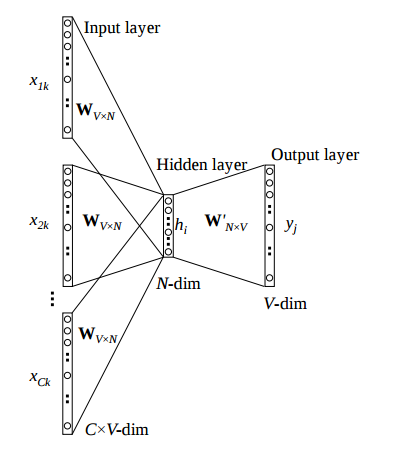

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men, and human might cluster in one corner, while yellow, red and blue cluster together in another.


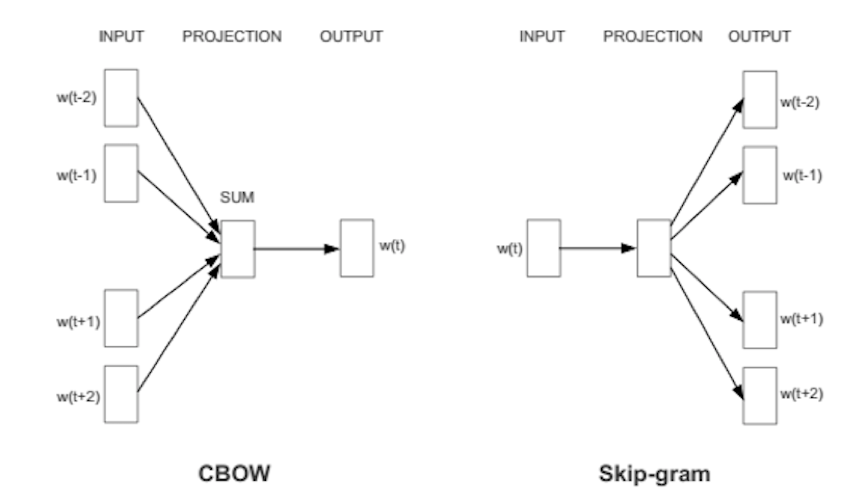

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. For instance, it will have two vector representations for Apple, one for the company and another for the fruit.

Default algo in Gensim is CBOW.

In [108]:
num_features = 50
min_word_count = 10
context_size = 10
downsampling = 1e-3
seed=1000

In [109]:
wine2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

Functions to create doument level embeddings from word embeddings by average- 

In [110]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")   # , ( left blank to adjust automatically)
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

In [111]:
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

### 5. Feature - points

In [112]:
data.columns

Index(['user_name', 'country', 'review_title', 'review_description', 'points',
       'price', 'winery', 'variety'],
      dtype='object')

In [113]:
data.points.describe()

count    77641.000000
mean        88.541222
std          3.141503
min         80.000000
25%         86.000000
50%         88.000000
75%         91.000000
max        100.000000
Name: points, dtype: float64

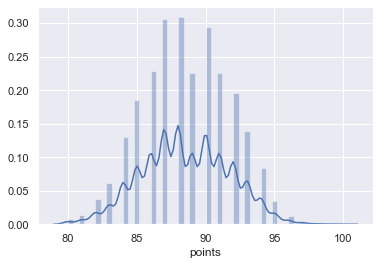

In [121]:
sns.distplot(data.points)

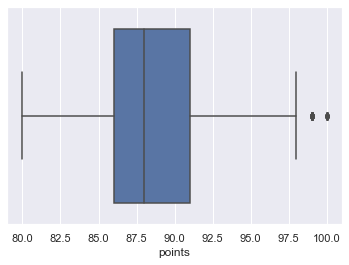

In [124]:
sns.boxplot(data.points)

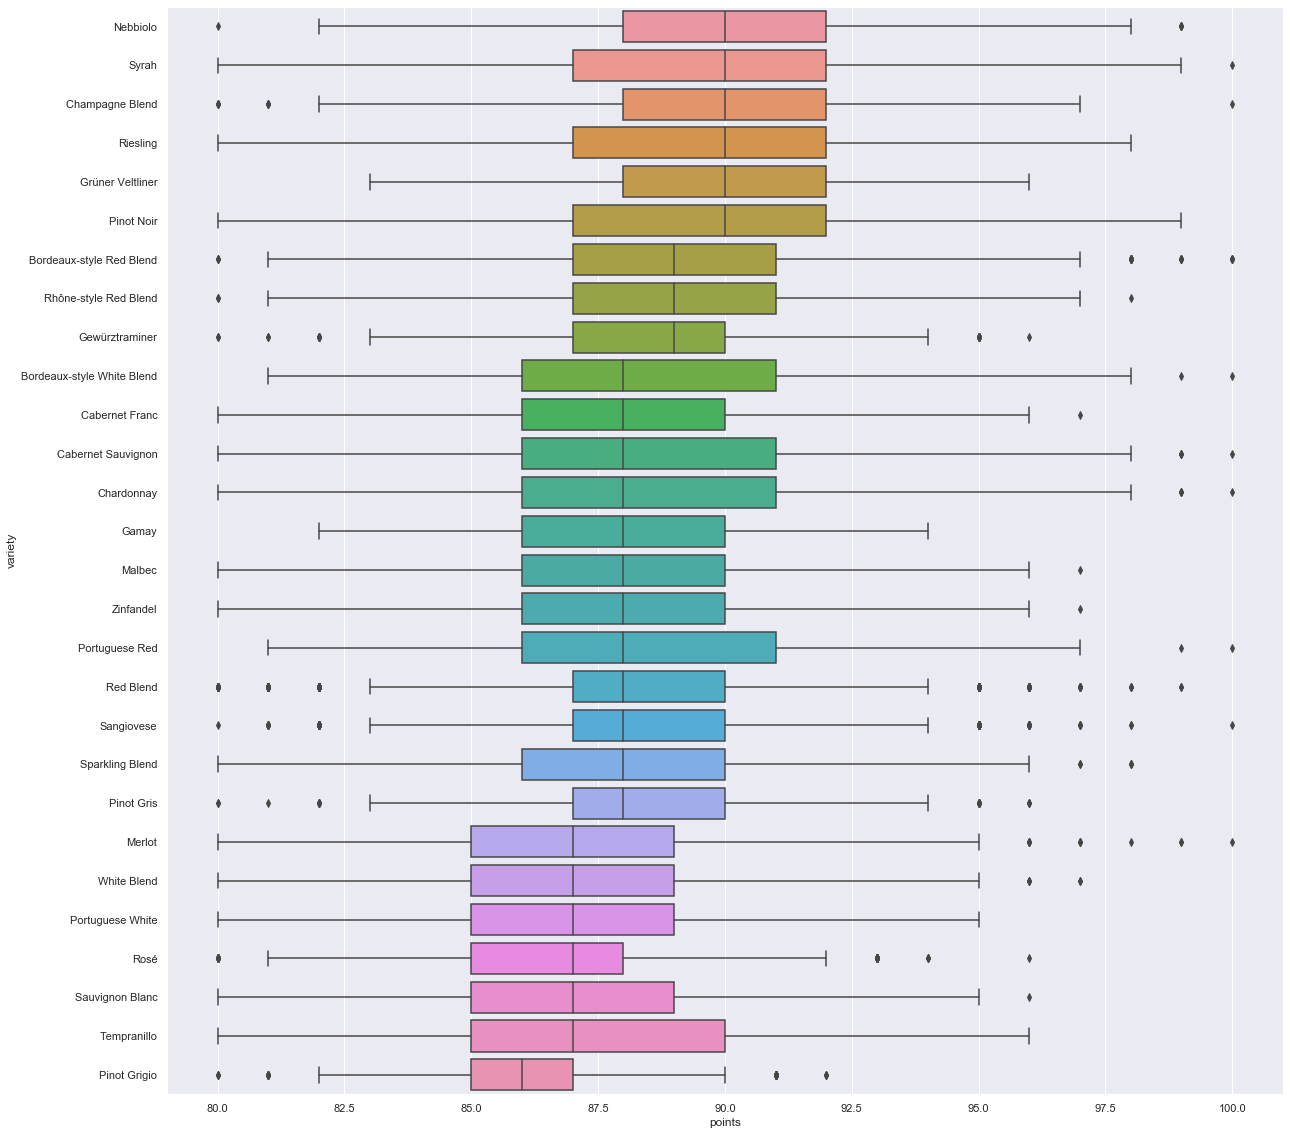

In [135]:
plt.figure(figsize=(20,20))
sns.boxplot(data.points,data.variety,order=data.groupby(['variety'])['points'].median().sort_values(ascending=False).keys())
plt.show()

Inferences - 
1. Lowest value is 80 highest being 100. Wines below 80 are considered poor wines, and hence in the present dataset only wines with points greater than or equal to 80 were included. 
2. Mean and median are preety close (88.54 , and 88)
3. Points are all int values 
4. From box plot we see that some outliers are present in points beyond the right extreme values (as expected)
5. From the points vs variety box plots , we can see that there exists almost 5 groups of wine variety with equal medians(and similar distributions)
6. Nebbiolio and Syrah turn out to be highest rated variety. 
7. Pinot Grigio is the poorest performer, with a very small spread. 


I will now convert the points into bins-

Function - 

In [136]:
def cat_points(points):    
    if points in list(range(80,84)):
        return 0
    elif points in list(range(84,88)):
        return 1
    elif points in list(range(88,92)):
        return 2
    elif points in list(range(92,96)):
        return 3
    else:
        return 4

### 6. Feature - price

In [139]:
data.price.isnull().sum()

5285

#### There are NULL values in price. I will impute them with median value for now.

In [141]:
data.price.fillna(data.price.median(),inplace=True)

In [142]:
data.price.describe()

count    77641.000000
mean        36.449943
std         43.155313
min          4.000000
25%         18.000000
50%         27.000000
75%         44.000000
max       3300.000000
Name: price, dtype: float64

Plot of price:


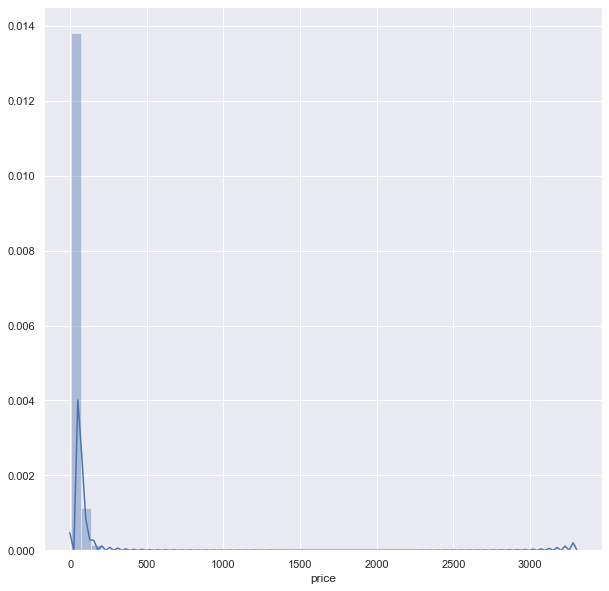

In [155]:
print("Plot of price:")
plt.figure(figsize=(10,10))
sns.distplot(data.price)
plt.show()

Plot of price after log transformation:


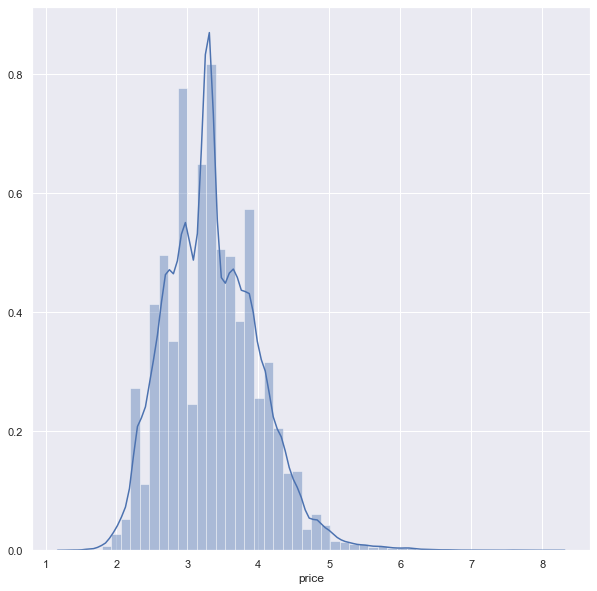

In [156]:
print("Plot of price after log transformation:")
plt.figure(figsize=(10,10))
sns.distplot(np.log(data.price))
plt.show()

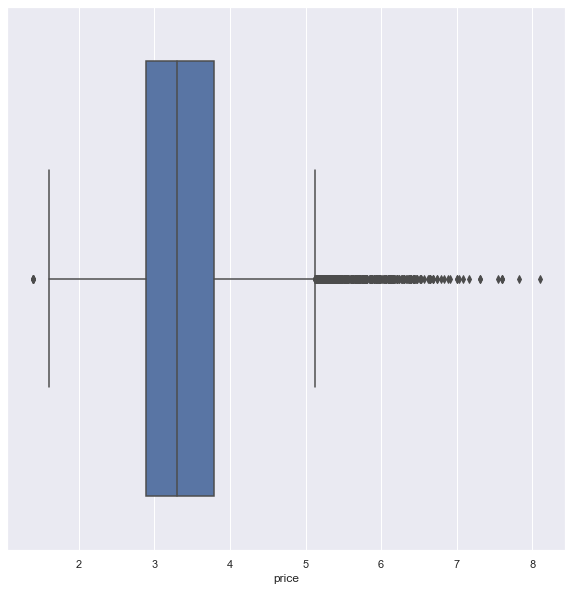

In [154]:
plt.figure(figsize=(10,10))
sns.boxplot(np.log(data.price))
plt.show()

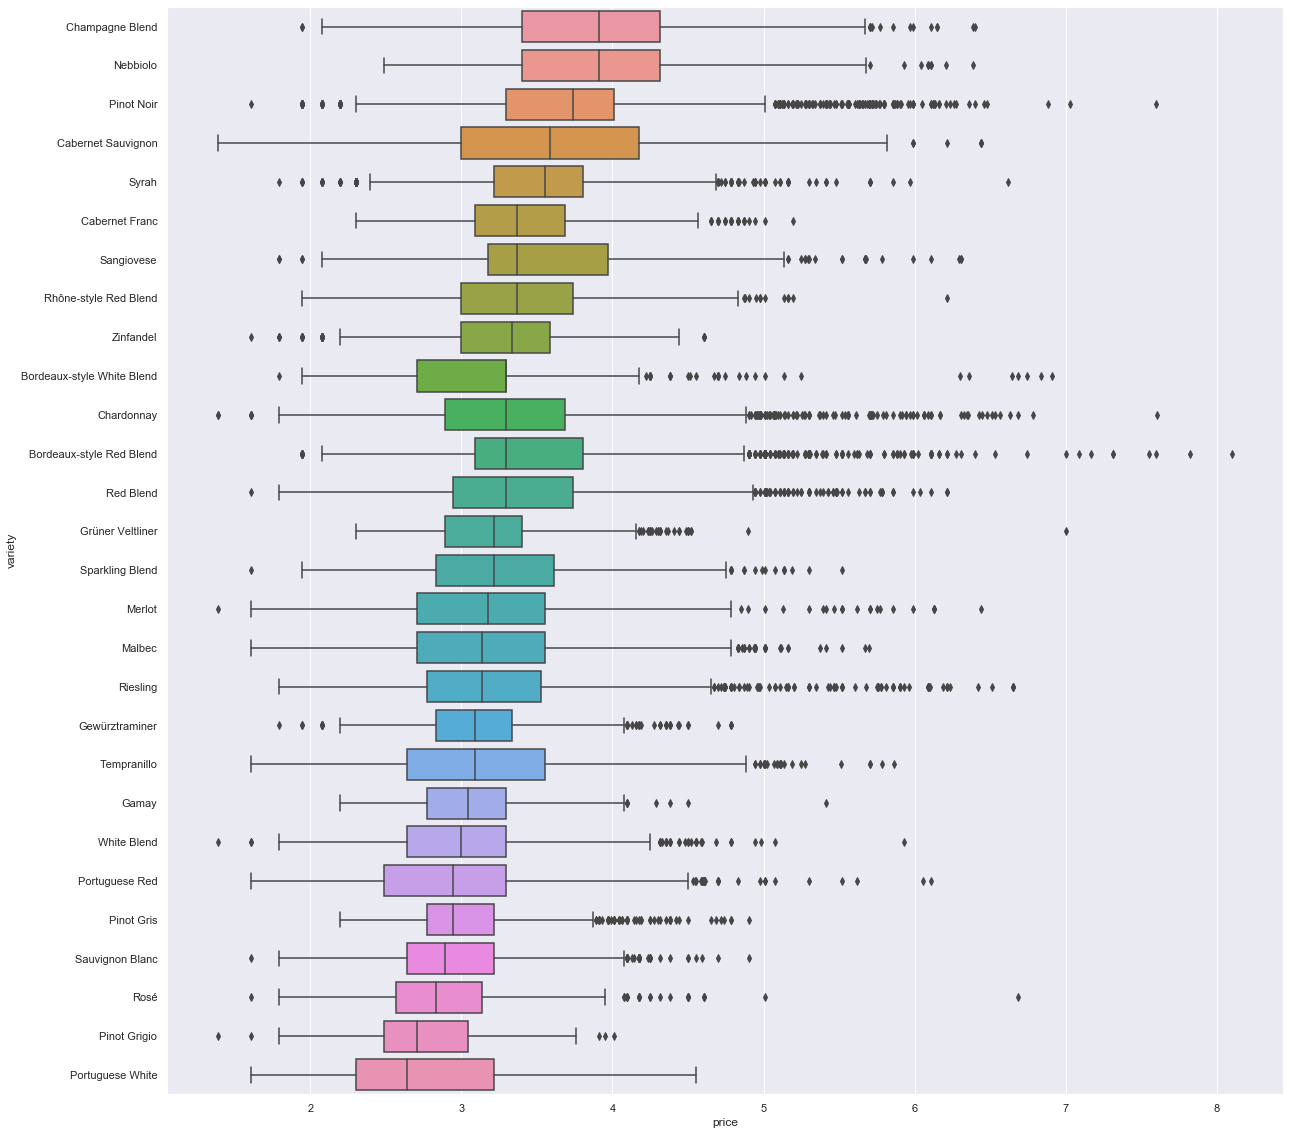

In [152]:
plt.figure(figsize=(20,20))
sns.boxplot(np.log(data.price),data.variety,order=data.groupby(['variety'])['price'].median().sort_values(ascending=False).keys())
plt.show()

Inferences - 
1. Lowest price is 4 while the highest being 3300. The mean (36.44) is substantially greater than the median (27) hence it indicates price feature is right skewed (as expected) 
2. As the price feature is highly right skewed, transforming by log transformation leads plots that are better readable.
3. From box plot it is evident that some outliers are present in price beyond the right extreme values (as expected)
4. From the price vs variety box plots , we can find intresting findings such as 'Champagne Blend' has the highest median , but 'Bordeaux-style Red Blend' has a larger spread and higher values of outliers. 
5. Nebbiolio and Champagne Blendturn out to be highest priced variety. 
6. Portuguese White and Pinot Grigio are the cheapest variety. 


#### Note - Price is highly right skewed , however it need not be transformed when using non-linear algorithms like CART, Random Forest.The way Random Forests are built is invariant to monotonic transformations of the independent variables. When we do log transformation for independent variables it may smooth out the information that allows this algorithm to perform properly. 

### 7. Plot of price vs points- 

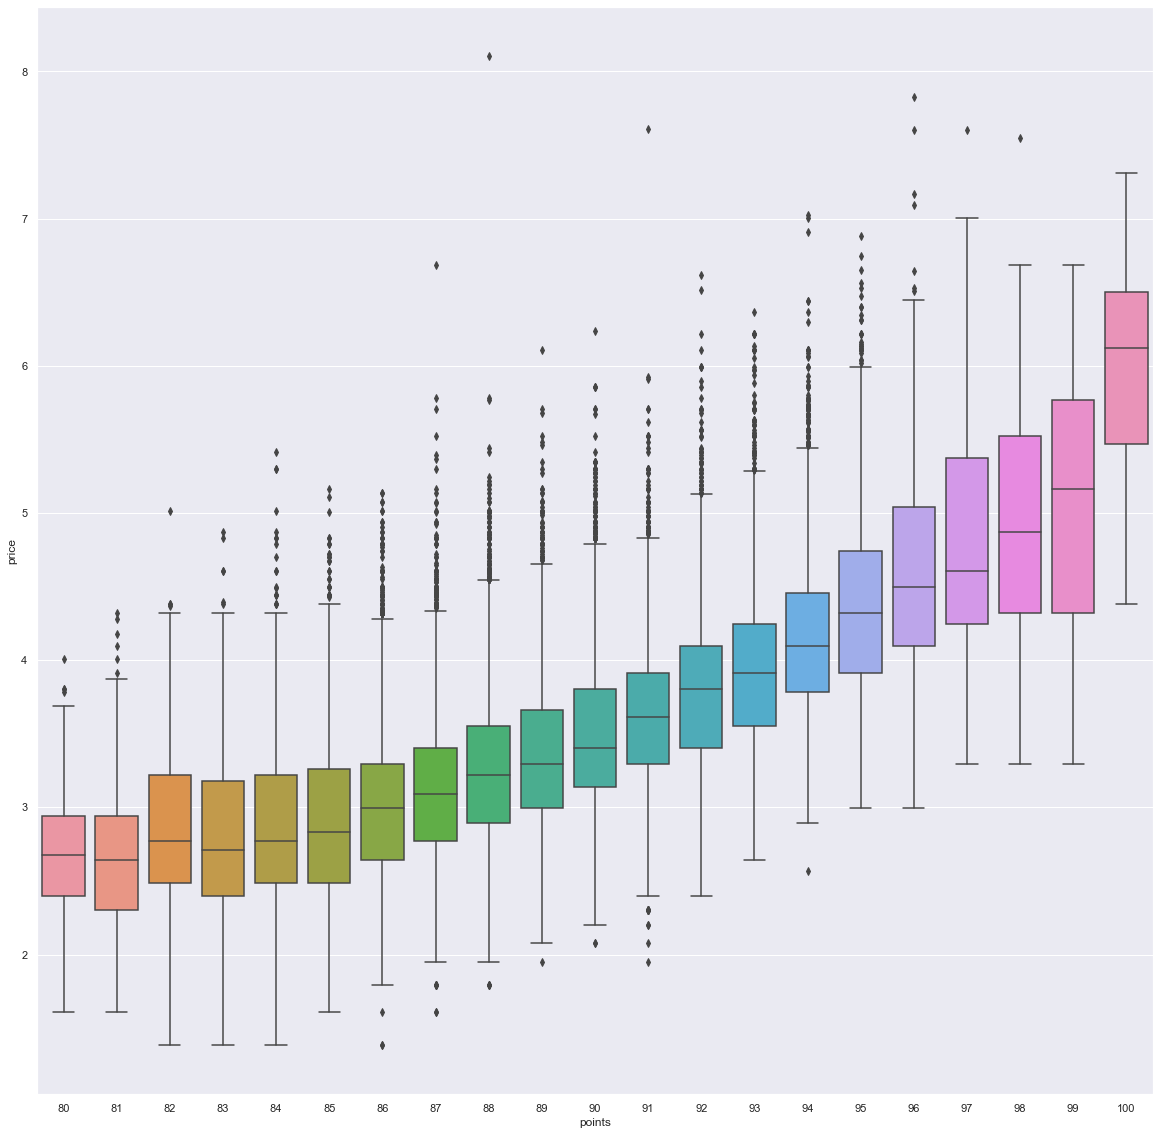

In [159]:
plt.figure(figsize=(20,20))
sns.boxplot(y=np.log(data.price),x=data.points)
plt.show()

In [162]:
data[data.price==data.price.max()]

,user_name,country,review_title,review_description,points,price,winery,variety
57505,@vossroger,France,Château les Ormes Sorbet 2013 Médoc,This ripe wine shows plenty of blackberry frui...,88,3300.0,Château les Ormes Sorbet,Bordeaux-style Red Blend


In [167]:
data[data.variety=="Bordeaux-style Red Blend"].groupby('country').price.describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
Argentina,67.0,39.910448,22.694100,10.0,25.00,33.0,50.00,110.0
Australia,21.0,60.571429,35.531073,20.0,30.00,52.0,85.00,145.0
Austria,2.0,36.500000,9.192388,30.0,33.25,36.5,39.75,43.0
Brazil,2.0,22.500000,17.677670,10.0,16.25,22.5,28.75,35.0
Bulgaria,1.0,25.000000,NaN,25.0,25.00,25.0,25.00,25.0
Canada,11.0,46.272727,28.053844,25.0,31.00,33.0,50.00,120.0
Chile,28.0,53.607143,28.434902,12.0,26.75,55.0,78.00,100.0
Croatia,1.0,13.000000,NaN,13.0,13.00,13.0,13.00,13.0
France,3570.0,37.801401,105.779353,7.0,19.00,27.0,27.00,3300.0


Inferences - 
1. Clear relationship of price and points , higher the points higher will be the median price of the variety. 
2. In france you can find the least expensive and most expensive Bordeaux-style Red Blend across the countries. Also the spread (standard deviation) is quite large in france, which also happens to be most reviewed country for Bordeaux-style Red Blend. 
3. The most expensive wine reviewed in the dataset surprisingly is an average rated wine variety  (Bordeaux-style Red Blend)



### 8. Feature - variety (target variable)

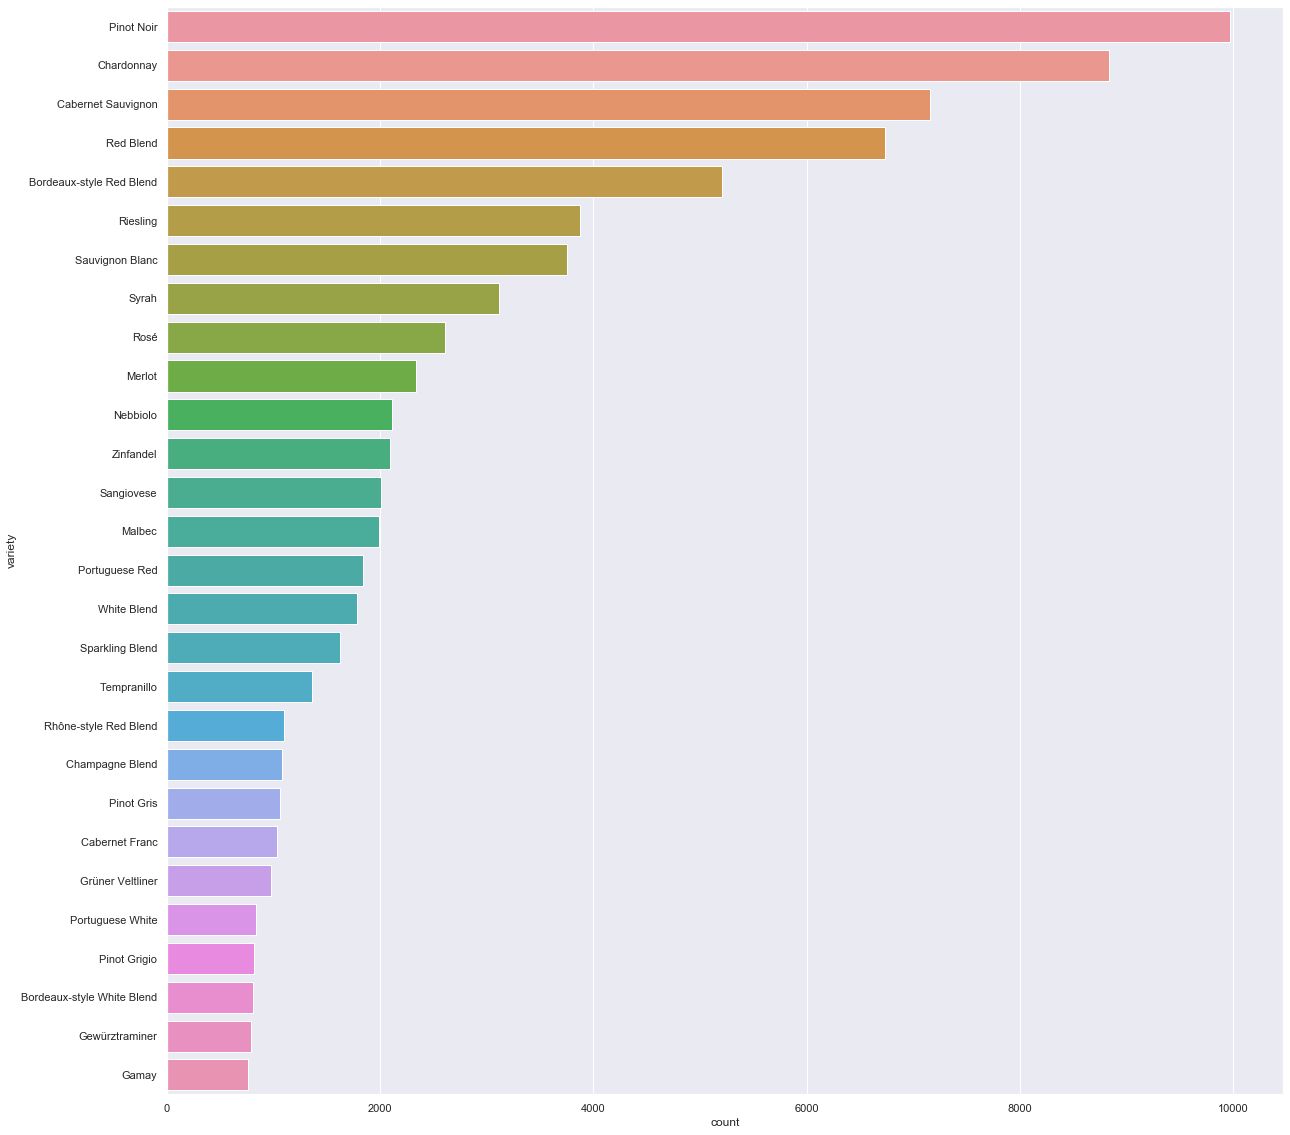

In [171]:
plt.figure(figsize=(20,20))
sns.countplot(y=data.variety,order=data.variety.value_counts().keys())
plt.show()

In [175]:
len(data.variety.unique())

28

Inferences- 
1. A total of 28 varities are present in the dataset.
2. The target variable is highly imbalanced , the wine variety native to the country where this dataset was created will take the top positions(Pinot Noir , Chardonnay and Cabernet Sauvignon belonging to US )  
3. This imbalance will continue to be present in the future data as well (unseen) , hence I am not opting for any imbalance removal technique like over-sampling , under-sampling or SMOTE . Can be tried for further improvements. 

##### This concludes the EDA. Moving to data preparation step. 
### Data Prepartion - 

In [239]:
data.shape

(77641, 7)

In [240]:
y = data.variety
data_model=data.copy(deep=True)
data_model= data_model.drop('variety',axis=1)

In [241]:
def data_process(data_frame):
    data_frame['user_name']= data_frame['user_name'].apply(username_bins_func)
    data_frame['country']= data_frame['country'].apply(country_bin)
    data_frame['vintage']= data_frame['review_title'].apply(extract_vintage)
    data_frame['hint_variety']= data_frame['review_title'].apply(seek_variety)
    data_frame = data_frame.drop('review_title',axis=1)
    data_frame['points']= data_frame['points'].apply(cat_points)
    data_frame['review_description']= data_frame['review_description'].apply(clean_desc)
    return(data_frame)
    

In [242]:
X = data_process(data_model)

In [243]:
X_copy=X.copy(deep=True)

In [244]:
X.iloc[0:10]

,user_name,country,review_description,points,price,vintage,hint_variety
0,unknown,Others,"[classic, chardonnay, aroma, apple, pear, hay,...",0,10.0,2007,chardonnay
1,@wawinereport,US,"[wine, near, equal, part, syrah, merlot, balan...",2,15.0,2014,Not found
2,unknown,Italy,"[barolo, conca, open, inky, dark, concentratio...",3,80.0,2007,Not found
3,@vossroger,France,"[impressive, small, addition, sauvignon, gris,...",1,22.0,2010,Not found
4,@vossroger,France,"[ripe, sweet, wine, rich, full, dried, fresh, ...",2,33.0,2012,malbec
5,@wineschach,Others,"[strident, aroma, licorice, herb, berry, mint,...",1,13.0,2005,cabernet sauvignon
6,@wawinereport,US,"[half, syrah, half, cabernet, sauvignon, new, ...",2,45.0,2012,Not found
7,@vboone,US,"[high, toned, red, fruit, star, wine, nice, sh...",2,50.0,2014,zinfandel
8,@paulgwine,US,"[displaying, typical, mcminnville, ava, subtle...",2,48.0,2014,pinot noir
9,@kerinokeefe,Italy,"[blend, sangiovese, merlot, open, aroma, fores...",1,31.0,2009,Not found


In [245]:
X.dtypes

user_name              object
country                object
review_description     object
points                  int64
price                 float64
vintage                 int64
hint_variety           object
dtype: object

In [232]:
#Check for NULL- 
X.isnull().sum()

user_name               0
country                 0
review_description      0
points                  0
price                   0
vintage                 0
hint_variety          168
dtype: int64

In [246]:
X.hint_variety.fillna("Not found",inplace=True)

#### One Hot Encoding Categorical variables -

In [247]:
review_desc= X.review_description   # seperating review before encoding
X=X.drop("review_description",axis=1)

In [248]:
X.head()

,user_name,country,points,price,vintage,hint_variety
0,unknown,Others,0,10.0,2007,chardonnay
1,@wawinereport,US,2,15.0,2014,Not found
2,unknown,Italy,3,80.0,2007,Not found
3,@vossroger,France,1,22.0,2010,Not found
4,@vossroger,France,2,33.0,2012,malbec


In [249]:
one_hot= OneHotEncoder(cols=["user_name","country","hint_variety"],use_cat_names=True)  # OneHotEncoder from category_encoders package
one_hot.fit(X)

OneHotEncoder(cols=['user_name', 'country', 'hint_variety'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

In [250]:
X=one_hot.transform(X)

In [253]:
X.columns

Index(['user_name_unknown', 'user_name_@wawinereport', 'user_name_@vossroger',
       'user_name_@wineschach', 'user_name_@vboone', 'user_name_@paulgwine ',
       'user_name_@kerinokeefe', 'user_name_@JoeCz', 'user_name_@AnneInVino',
       'user_name_@mattkettmann', 'user_name_@gordone_cellars',
       'country_Others', 'country_US', 'country_Italy', 'country_France',
       'country_Portugal', 'points', 'price', 'vintage',
       'hint_variety_chardonnay', 'hint_variety_Not found',
       'hint_variety_malbec', 'hint_variety_cabernet sauvignon',
       'hint_variety_zinfandel', 'hint_variety_pinot noir',
       'hint_variety_sauvignon blanc', 'hint_variety_grüner veltliner',
       'hint_variety_syrah', 'hint_variety_cabernet franc',
       'hint_variety_rosé', 'hint_variety_sangiovese', 'hint_variety_merlot',
       'hint_variety_riesling', 'hint_variety_pinot grigio',
       'hint_variety_pinot gris', 'hint_variety_tempranillo',
       'hint_variety_gewürztraminer', 'hint_variety_

#### Word2vec implementation -

In [259]:
wine2vec.build_vocab(review_desc.values) 

In [260]:
print('Word2Vec vocabulary length:', len(wine2vec.wv.vocab))
print("Documents:", wine2vec.corpus_count)

Word2Vec vocabulary length: 6330
Documents: 77641


In [261]:
wine2vec.train(review_desc.values, total_examples=wine2vec.corpus_count, epochs=wine2vec.iter)

C:\Users\rp\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """Entry point for launching an IPython kernel.


(8014058, 9735100)

In [262]:
# get document level embeddings to be used in modeling 
w2v_feature_array = averaged_word_vectorizer(corpus=review_desc, model=wine2vec,   #function to get vectors
                                             num_features=num_features)
review_dim= pd.DataFrame(w2v_feature_array)  # dataframe 

C:\Users\rp\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [263]:
review_dim.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.207916,0.323416,0.077551,0.183012,-0.241483,0.051227,-0.160633,-0.041264,0.277143,-0.020475,...,0.082053,0.154481,0.058791,-0.025718,0.293423,0.197968,0.291995,0.069211,-0.174065,-0.136154
1,0.117188,0.155040,0.063383,0.205506,-0.418185,0.145098,-0.037407,0.023138,0.311348,-0.094428,...,-0.016532,-0.101453,0.015682,-0.199149,0.107547,0.122285,0.392805,0.064175,-0.218447,-0.261861
2,0.054654,0.110254,0.010015,0.246529,-0.390284,0.013959,-0.137756,-0.164043,0.255575,0.152875,...,0.122331,-0.046564,0.338117,-0.049480,0.169884,0.163338,0.260957,-0.016971,-0.210140,-0.124132
3,0.087016,0.269126,0.383072,-0.024757,-0.526060,0.014644,-0.027115,0.092502,0.387406,-0.114510,...,-0.275587,0.071541,-0.036342,-0.095656,0.187665,0.164355,0.185636,0.052013,-0.130327,-0.083053
4,0.172835,0.123420,0.086061,0.297273,-0.329120,-0.039726,-0.148740,0.049839,0.146177,-0.014935,...,0.116770,0.014276,0.145523,-0.027395,0.310580,0.311778,0.295035,-0.029828,-0.233474,-0.160298


In [264]:
review_dim.shape

(77641, 50)

#### Merging the two data frames - (One with 50 word2vec dimensions , another with on hot encoded  features)

In [265]:
X_model = X.merge(review_dim,left_index=True,right_index=True)

In [266]:
X_model.head()

,user_name_unknown,user_name_@wawinereport,user_name_@vossroger,user_name_@wineschach,user_name_@vboone,user_name_@paulgwine,user_name_@kerinokeefe,user_name_@JoeCz,user_name_@AnneInVino,user_name_@mattkettmann,...,40,41,42,43,44,45,46,47,48,49
0,1,0,0,0,0,0,0,0,0,0,...,0.082053,0.154481,0.058791,-0.025718,0.293423,0.197968,0.291995,0.069211,-0.174065,-0.136154
1,0,1,0,0,0,0,0,0,0,0,...,-0.016532,-0.101453,0.015682,-0.199149,0.107547,0.122285,0.392805,0.064175,-0.218447,-0.261861
2,1,0,0,0,0,0,0,0,0,0,...,0.122331,-0.046564,0.338117,-0.049480,0.169884,0.163338,0.260957,-0.016971,-0.210140,-0.124132
3,0,0,1,0,0,0,0,0,0,0,...,-0.275587,0.071541,-0.036342,-0.095656,0.187665,0.164355,0.185636,0.052013,-0.130327,-0.083053
4,0,0,1,0,0,0,0,0,0,0,...,0.116770,0.014276,0.145523,-0.027395,0.310580,0.311778,0.295035,-0.029828,-0.233474,-0.160298


### Splitting the data into train and test set - 

In [268]:
X_train,X_test,y_train,y_test= train_test_split(X_model,y,random_state=100,stratify=y)

In [269]:
rf=RandomForestClassifier(random_state=100,max_depth=11,min_samples_split=15,criterion='entropy')
rf.fit(X_train,y_train)rf.score(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [273]:
print("Results-")
print("Accuracy on train:{0:.3f}".format(rf.score(X_train,y_train)))
print("Accuracy on test:{0:.3f}".format(rf.score(X_test,y_test)))
print("f1 score on train :{0:.3f}".format(f1_score(y_train,rf.predict(X_train),average='weighted')))
print("f1 score on test :{0:.3f}".format(f1_score(y_test,rf.predict(X_test),average='weighted')))

Results-
Accuracy on train:0.869
Accuracy on test:0.852
f1 score on train :0.858
f1 score on test :0.840


In [282]:
pd.DataFrame(rf.feature_importances_*100,X_train.columns)[0].sort_values(ascending=False)

hint_variety_Not found             12.200257
hint_variety_pinot noir             8.095749
hint_variety_cabernet sauvignon     6.915801
hint_variety_chardonnay             6.321499
hint_variety_riesling               3.678693
41                                  3.615945
26                                  3.472145
user_name_@vossroger                3.115351
hint_variety_syrah                  2.953075
country_France                      2.884734
hint_variety_sauvignon blanc        2.817167
country_Italy                       2.380602
hint_variety_rosé                   2.292234
country_Portugal                    2.112377
hint_variety_merlot                 2.024290
hint_variety_zinfandel              1.920803
44                                  1.851636
hint_variety_malbec                 1.664422
country_US                          1.556446
12                                  1.496299
30                                  1.332658
39                                  1.051046
0         

Feature Importance:


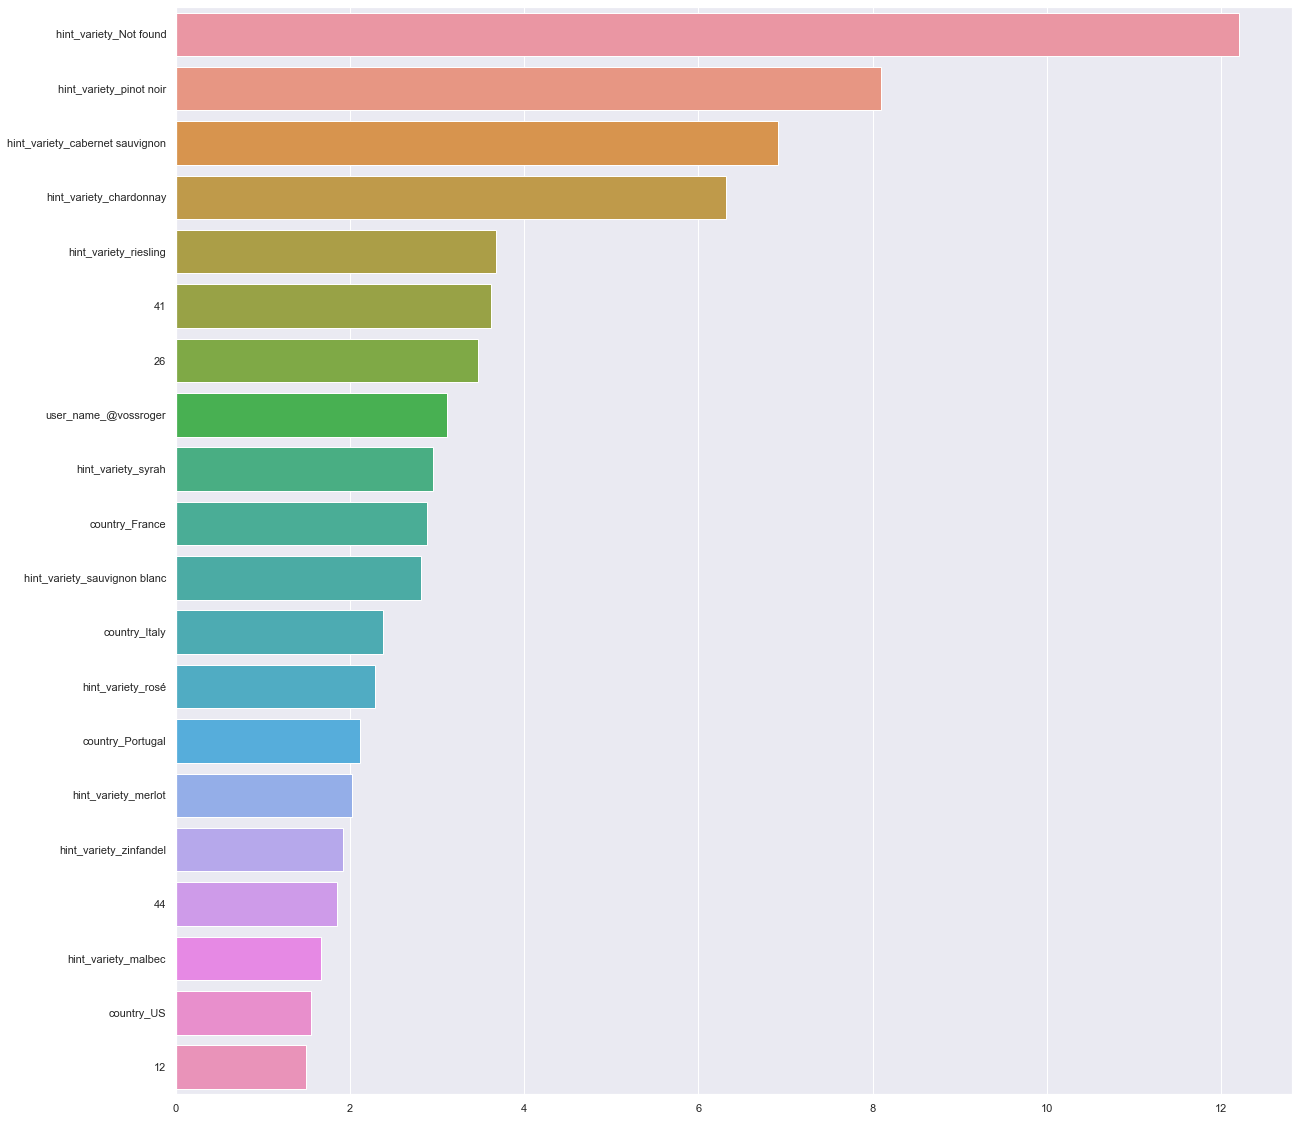

In [291]:
print("Feature Importance:")
plt.figure(figsize=(20,20))
sns.barplot(x=rf.feature_importances_*100,y=X_train.columns,order=pd.DataFrame(rf.feature_importances_*100,X_train.columns)[0].sort_values(ascending=False).keys()[:20])
plt.show()

#### Playing devil's advocate, I will now remove the review_description (dimensions features) from a similar model to see what the performance is - 

In [293]:
X_train_trial,X_test_trial,y_train_trial,y_test_trial= train_test_split(X,y,random_state=100,stratify=y)  # X is the df without review dim
rf_trial=RandomForestClassifier(random_state=100,max_depth=11,min_samples_split=15,criterion='entropy')
rf_trial.fit(X_train_trial,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [276]:
print("Results ( Without using reviews dimensions ) -")
print("Accuracy on train:{0:.3f}".format(rf_trial.score(X_train_trial,y_train)))
print("Accuracy on test:{0:.3f}".format(rf_trial.score(X_test_trial,y_test)))
print("f1 score on train :{0:.3f}".format(f1_score(y_train,rf_trial.predict(X_train_trial),average='weighted')))
print("f1 score on test :{0:.3f}".format(f1_score(y_test,rf_trial.predict(X_test_trial),average='weighted')))

Results ( Without using reviews dimensions ) -
Accuracy on train:0.808
Accuracy on test:0.806
f1 score on train :0.798
f1 score on test :0.796


Feature Importance:


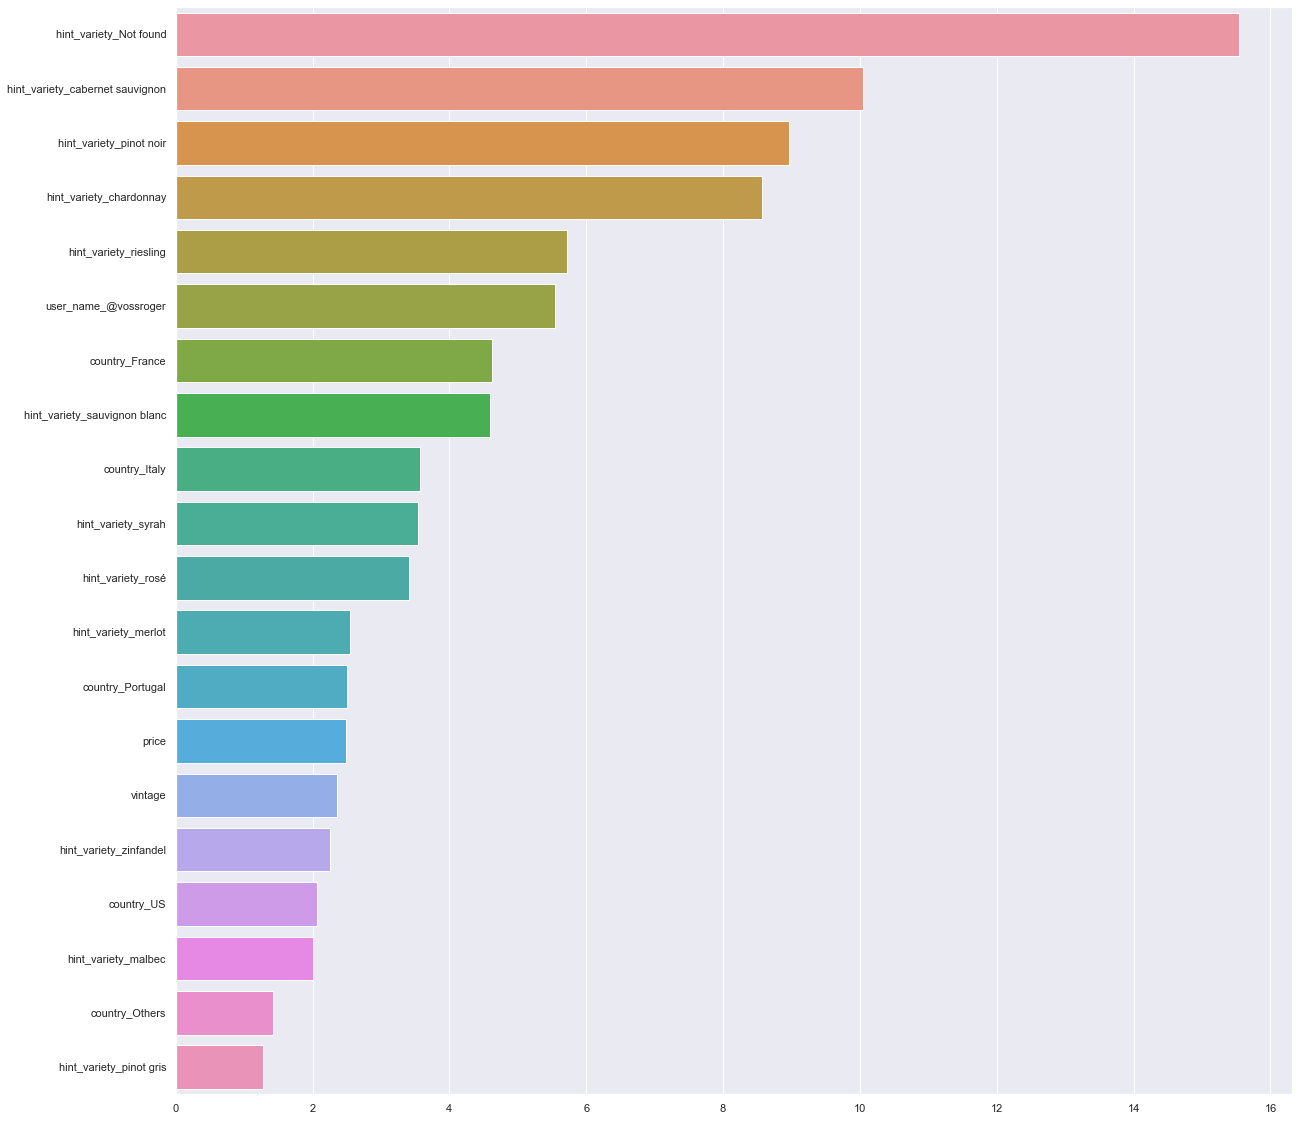

In [294]:
print("Feature Importance:")
plt.figure(figsize=(20,20))
sns.barplot(x=rf_trial.feature_importances_*100,y=X_train_trial.columns,order=pd.DataFrame(rf_trial.feature_importances_*100,X_train_trial.columns)[0].sort_values(ascending=False).keys()[:20])
plt.show()

#### Making a predictive model with only the review_description( dimensions features ) -

In [283]:
X_train_trial,X_test_trial,y_train_trial,y_test_trial= train_test_split(review_dim,y,random_state=100,stratify=y)  # X is the df without review dim
rf_trial_2=RandomForestClassifier(random_state=100,max_depth=11,min_samples_split=15,criterion='entropy')
rf_trial_2.fit(X_train_trial,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=11, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [284]:
print("Results ( Using only reviews dimensions ) -")
print("Accuracy on train:{0:.3f}".format(rf_trial_2.score(X_train_trial,y_train)))
print("Accuracy on test:{0:.3f}".format(rf_trial_2.score(X_test_trial,y_test)))
print("f1 score on train :{0:.3f}".format(f1_score(y_train,rf_trial_2.predict(X_train_trial),average='weighted')))
print("f1 score on test :{0:.3f}".format(f1_score(y_test,rf_trial_2.predict(X_test_trial),average='weighted')))

Results ( Using only reviews dimensions ) -
Accuracy on train:0.633
Accuracy on test:0.513
f1 score on train :0.598
f1 score on test :0.464


#### Final Words - 
1. Results obtained by using review_description(text feature) along with other independent features gives better results then in model where review_description is not included in model. An increase of about 5% in both accuracy as well as weighted f1 scores. 
2. Results-  
   Accuracy- 
   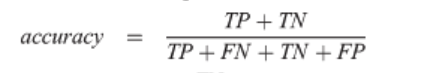
   
   Accuracy on train set :0.869
   
   Accuracy on test set  :0.852

   Weighted f1 score-  Weighted f1 score is a good metric incase of multi-class classification problems 
   
   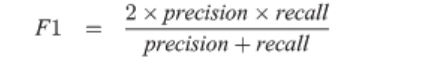
   
   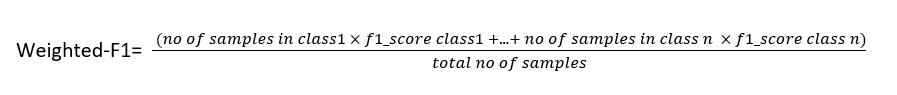
   
   

     f1 score on train :0.858
   
     f1 score on test  :0.840


2. max_depth=11,min_samples_split=15,criterion='entropy' are the hyper parameter values that were obtained after extensive Hyperparameter tuning process using RandomizedSearchCV. Using these values lead to a pruned Random Forest classifier, not suffering from  over-fit or under-fit. 

   The param_grid used for RandomizedSearchCV was - 
   
   param_grid ={ 'max_depth':[10,11,12,15,20], 'min_samples_split':[10,15,20,25],'criterion'=['entropy','gini']}
   
   Note- Hyperparameter tuning is not presented in the current notebook.                          


3. When using only review_description(text feature) for classification, lower accuracy and f1 scores were observed. This is indicative of the fact that further work needs to be done to increase the results. Some ways to do so could be - 
   
   i.  Removing the Stop Words(frequent occuring words) specific to the Domain (wine in this case)  
   
   ii. Tweaking the number of dimensions used for word and document embedding
   
   iii.Using other embedding algorithm(GLOVE , or DNN) 
   
   iv. Hyperparameter tuning will have to repeated for the new set of features to obtain a generalised model. 

4. As expected , hint_variety feaures along with country features(country_France,country_Italy) are among the most important predictors. This backs up the notion that some varities of wine are country specific. 

### THE END !!! 